In [9]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import random
from pyHalo.preset_models import CDM

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses import strong_lens
from mejiro.utils import util

In [10]:
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)
lens = random.choice(lens_list)

In [11]:
pipeline_params = util.hydra_to_dict(config.pipeline)
subhalo_cone = pipeline_params['subhalo_cone']
los_normalization = pipeline_params['los_normalization']

# circumvent bug with pyhalo, sometimes fails when redshifts have more than 2 decimal places
z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)

# randomly generate CDM subhalos
log_m_host = np.log10(lens.main_halo_mass)
r_tidal = 0.25
sigma_sub = 0.055
cdm_realization = CDM(z_lens,
                      z_source,
                      sigma_sub=sigma_sub,
                      log_mlow=6.,
                      log_mhigh=10.,
                      log_m_host=log_m_host,
                      r_tidal=r_tidal,
                      cone_opening_angle_arcsec=subhalo_cone,
                      LOS_normalization=los_normalization)

In [12]:
num_pix = 45
oversample = 5
side = 4.95
band = 'F106'

original_array = lens.get_array(num_pix=num_pix * oversample, side=side, band=band)

In [13]:
lens.add_subhalos(cdm_realization, suppress_output=False)

Original Einstein radius: 1.0050 arcsec
Adjusted Einstein radius: 1.0029 arcsec
Percent change of Einstein radius: 0.22%
------------------------------------
Effective lensing mass: 2.9341e+11 M_Sun
Adjusted lensing mass: 2.9214e+11 M_Sun
Percent change of lensing mass: 0.43%
------------------------------------
Total mass of CDM halos within Einstein radius: 1.2691e+09 M_Sun
Total mass of CDM halos: 1.1482e+10 M_Sun
Percentage of total subhalo mass within Einstein radius: 11.05%




In [14]:
with_subhalos_array = lens.get_array(num_pix=num_pix * oversample, side=side, band=band)

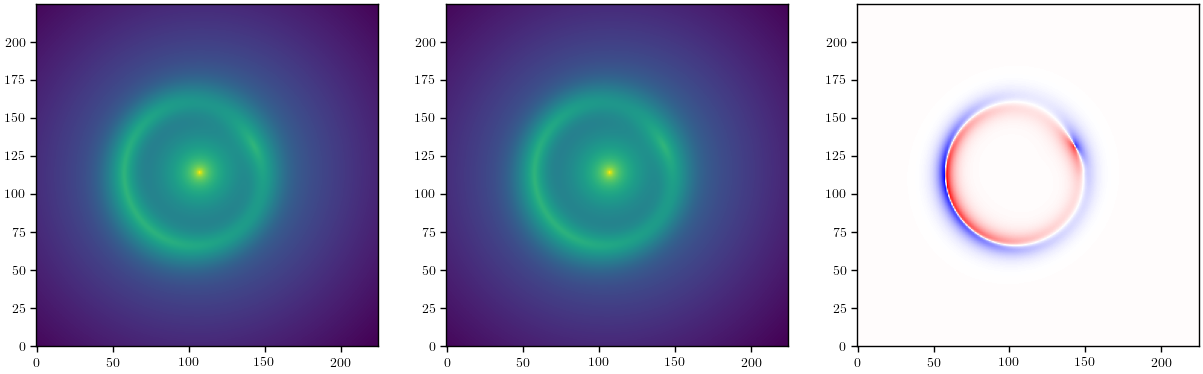

In [15]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(original_array))
ax[1].imshow(np.log10(with_subhalos_array))
ax[2].imshow(with_subhalos_array - original_array, cmap='bwr')
plt.show()

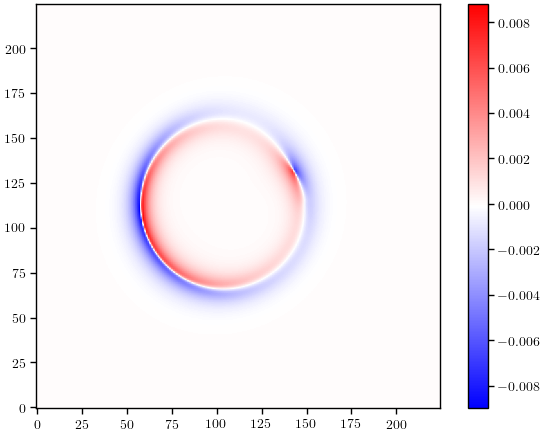

In [16]:
plt.imshow(with_subhalos_array - original_array, cmap='bwr')
plt.colorbar()
plt.show()